In [2]:
import os
import h5py
import pandas as pd

# Path to your HDF5 file (assumes it's in the current working directory)
file_path = 'model3b.h5'

# 1) Show files in the working directory
print("Files in working directory:", os.listdir())

# 2) Open the HDF5 and list datasets
dataset_paths = []
with h5py.File(file_path, 'r') as f:
    print("\nHDF5 Structure:")
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  Dataset: {name} | shape={obj.shape} | dtype={obj.dtype}")
            dataset_paths.append(name)
    f.visititems(visitor)

# 3) If any datasets found, load the first one into a DataFrame and print preview
if dataset_paths:
    first_ds = dataset_paths[0]
    with h5py.File(file_path, 'r') as f:
        data = f[first_ds][()]
        try:
            df = pd.DataFrame(data)
            print(f"\nFirst few rows of '{first_ds}':")
            print(df.head())
        except Exception as e:
            print(f"Could not convert '{first_ds}' to DataFrame: {e}")
else:
    print("No datasets found in the HDF5 file.")


Files in working directory: ['.git', '.ipynb_checkpoints', 'Axial Fetch.ipynb', 'README.md', 'MJ03E-B', 'MJ03F-B', 'MJ03F-E', 'FETCH StreamLine Final.ipynb', 'Data_230912111909_East_006870_2502_.csv', 'Data_230912112033_West_006874_2503_.csv', 'Data_230913091309_North_00687A_2504_.csv', 'R2504_2502.pkl', 'R2504_2503.pkl', 'R2503_2502.pkl', 'R2503_2504.pkl', 'R2502_2503.pkl', 'R2502_2504.pkl', '2504.pkl', 'Axial Modeling West.ipynb', 'Axial Modeling East.ipynb', 'model3b.h5', 'Untitled.ipynb']

HDF5 Structure:
  Dataset: Z | shape=(1152, 1021) | dtype=float64
  Dataset: lat | shape=(1152, 1021) | dtype=float64
  Dataset: lon | shape=(1152, 1021) | dtype=float64
  Dataset: m | shape=(574,) | dtype=float64
  Dataset: mpr_lat | shape=(9,) | dtype=float64
  Dataset: mpr_lon | shape=(9,) | dtype=float64
  Dataset: mpr_z | shape=(9,) | dtype=float64
  Dataset: rectangles | shape=(574, 4, 3) | dtype=float64

First few rows of 'Z':
       0         1         2         3         4         5     

In [3]:
import os
import h5py
import pandas as pd

# 0) Verify the file is in your working directory
print("Files here:", os.listdir('.'))

# 1) Open the file and discover its datasets
dataset_paths = []
with h5py.File('model3b.h5', 'r') as f:
    print("\nHDF5 contents:")
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  {name} — shape={obj.shape}, dtype={obj.dtype}")
            dataset_paths.append(name)
    f.visititems(visitor)

# 2) Load each dataset into memory
with h5py.File('model3b.h5', 'r') as f:
    data = { path: f[path][()] for path in dataset_paths }

# 3a) Example: turn the big grids into DataFrames
df_Z   = pd.DataFrame(data['Z'])
df_lat = pd.DataFrame(data['lat'])
df_lon = pd.DataFrame(data['lon'])

print("\nZ (5×5 corner):")
print(df_Z.iloc[:5, :5])

print("\nlat (5×5 corner):")
print(df_lat.iloc[:5, :5])

print("\nlon (5×5 corner):")
print(df_lon.iloc[:5, :5])

# 3b) Example: the 1D vectors
print("\nm (first 10 entries):")
print(pd.DataFrame({'m': data['m']}).head(10))

print("\nmpr points (all 9 rows):")
print(pd.DataFrame({
    'mpr_lat': data['mpr_lat'],
    'mpr_lon': data['mpr_lon'],
    'mpr_z':   data['mpr_z'],
}))

# 3c) Example: flatten the rectangles array (574×4×3) into a table
rects = data['rectangles']  # shape (574,4,3)
rows = []
for i, corners in enumerate(rects):
    for j, (x, y, z) in enumerate(corners):
        rows.append({'rect_id': i, 'corner': j, 'x': x, 'y': y, 'z': z})
df_rect = pd.DataFrame(rows)

print("\nRectangles (first 10 rows):")
print(df_rect.head(10))


Files here: ['.git', '.ipynb_checkpoints', 'Axial Fetch.ipynb', 'README.md', 'MJ03E-B', 'MJ03F-B', 'MJ03F-E', 'FETCH StreamLine Final.ipynb', 'Data_230912111909_East_006870_2502_.csv', 'Data_230912112033_West_006874_2503_.csv', 'Data_230913091309_North_00687A_2504_.csv', 'R2504_2502.pkl', 'R2504_2503.pkl', 'R2503_2502.pkl', 'R2503_2504.pkl', 'R2502_2503.pkl', 'R2502_2504.pkl', '2504.pkl', 'Axial Modeling West.ipynb', 'Axial Modeling East.ipynb', 'model3b.h5', 'Untitled.ipynb']

HDF5 contents:
  Z — shape=(1152, 1021), dtype=float64
  lat — shape=(1152, 1021), dtype=float64
  lon — shape=(1152, 1021), dtype=float64
  m — shape=(574,), dtype=float64
  mpr_lat — shape=(9,), dtype=float64
  mpr_lon — shape=(9,), dtype=float64
  mpr_z — shape=(9,), dtype=float64
  rectangles — shape=(574, 4, 3), dtype=float64

Z (5×5 corner):
          0         1         2         3         4
0  0.000249  0.000249  0.000249  0.000249  0.000249
1  0.000251  0.000251  0.000251  0.000251  0.000251
2  0.000254

In [8]:
import VSM_forward
import h5py
import numpy as np
from pyproj import Proj, transform

In [16]:
# 1) Load everything from the .h5
with h5py.File('model3b.h5','r') as f:
    Z_saved = f['Z'][:]             # Saved vertical predictions
    m          = f['m'][:]            # (574,)
    rectangles = f['rectangles'][:]   # (574, 4, 3)
    lat        = f['lat'][:]          # (Ny, Nx)
    lon        = f['lon'][:]          # (Ny, Nx)

In [12]:
# 2) Reconstruct patches list from rectangles
patches = []
for rect in rectangles:
    # corners: [0]=top-left, [1]=top-right, [3]=bottom-left
    xtlc, ytlc, dtlc = rect[0]
    length = np.linalg.norm(rect[1][:2] - rect[0][:2])
    width  = np.linalg.norm(rect[3][:2] - rect[0][:2])
    # strike as azimuth of top edge
    dx, dy = rect[1][0] - rect[0][0], rect[1][1] - rect[0][1]
    strike = np.degrees(np.arctan2(dy, dx))
    # dip from vertical projection
    dz = rect[3][2] - rect[0][2]
    horiz = np.linalg.norm(rect[3][:2] - rect[0][:2])
    dip    = np.degrees(np.arctan2(-dz, horiz))
    patches.append({
        'xtlc': xtlc, 'ytlc': ytlc, 'dtlc': dtlc,
        'length': length, 'width': width,
        'strike': strike, 'dip': dip
    })

In [13]:
# 3) Project lat/lon → X/Y using pyproj
wgs84   = Proj('epsg:4326')
utm_proj = Proj(proj='utm', zone=10, northern=True, ellps='WGS84')
lon_f = lon.flatten()
lat_f = lat.flatten()
x_f, y_f = transform(wgs84, utm_proj, lon_f, lat_f)
X = x_f.reshape(lat.shape)
Y = y_f.reshape(lat.shape)

# 4) Compute horizontal & vertical predictions
UX = np.zeros_like(X)
UY = np.zeros_like(X)
UZ = np.zeros_like(X)

for j, patch in enumerate(patches):
    ux_flat, uy_flat, uz_flat = VSM_forward.okada(
        X.ravel(), Y.ravel(),
        patch['xtlc'], patch['ytlc'], -patch['dtlc'],
        patch['length'], patch['width'],
        patch['strike'], patch['dip'],
        0.0, 0.0, m[j], 'R', 0.25
    )
    UX += ux_flat.reshape(X.shape)
    UY += uy_flat.reshape(X.shape)
    UZ += uz_flat.reshape(X.shape)

print("UX, UY, and UZ computed on same grid as Z")


/tmp/ipykernel_2960269/2062203900.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_f, y_f = transform(wgs84, utm_proj, lon_f, lat_f)
/home/seismic/AxialFetch/VSM_forward.py:431: RuntimeWarning: invalid value encountered in subtract
  y = np.sin(strike) * nc - np.cos(strike) * ec + np.cos(dip) * W
/home/seismic/AxialFetch/VSM_forward.py:517: RuntimeWarning: invalid value encountered in multiply
  (np.sin(dip) * xi * q / (R * (R + eta))) - \


UX, UY, and UZ computed on same grid as Z


In [25]:
import utm
# flatten
lat_f = lat.flatten()
lon_f = lon.flatten()
# convert each point
xy = [utm.from_latlon(lat_f[i], lon_f[i])[:2] for i in range(len(lat_f))]
x_f, y_f = zip(*xy)
# reshape
X = np.array(x_f).reshape(lat.shape)
Y = np.array(y_f).reshape(lat.shape)


In [28]:
def get_displacement_array(X, Y, patch, m_j):
    # 1) translate X,Y to patch-local coords
    x_loc = X - patch['xtlc']
    y_loc = Y - patch['ytlc']
    # 2) call Okada on those
    ux_flat, uy_flat, uz_flat = VSM_forward.okada(
        x_loc.ravel(), y_loc.ravel(),
        0, 0, -patch['dtlc'],
        patch['length'], patch['width'],
        patch['strike'], patch['dip'],
        0.0, 0.0, m_j, 'R', 0.25
    )
    # 3) reshape back
    Ux = ux_flat.reshape(X.shape)
    Uy = uy_flat.reshape(X.shape)
    Uz = uz_flat.reshape(X.shape)
    return Ux, Uy, Uz


In [31]:
UX = np.zeros_like(X)
UY = np.zeros_like(X)
UZ = np.zeros_like(X)

for j, patch in enumerate(patches):
    ux_patch, uy_patch, uz_patch = get_displacement_array(X, Y, patch, m[j])
    UX += ux_patch
    UY += uy_patch
    UZ += uz_patch


NameError: name 'Z' is not defined

In [33]:
# now UZ should exactly reproduce Z
diff = UZ - Z_saved
print("Max abs diff:", np.nanmax(np.abs(diff)))

Max abs diff: 0.18644251551926883


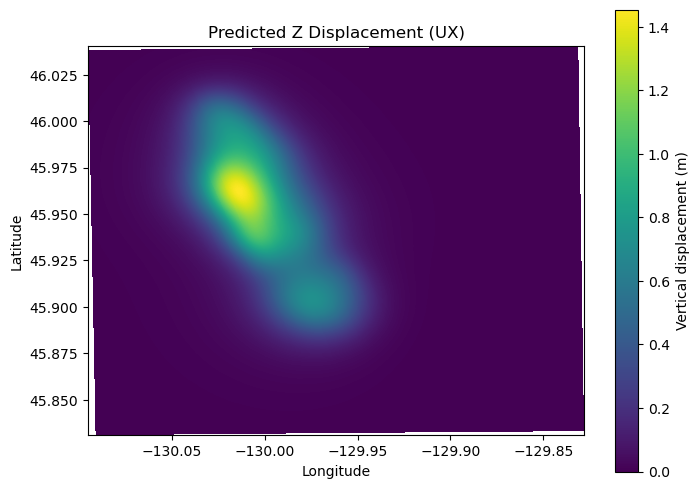

In [48]:
import matplotlib.pyplot as plt

# assume lat, lon, UZ are NumPy arrays of shape (Ny, Nx)
plt.figure(figsize=(8, 6))
plt.pcolormesh(lon, lat, UZ, shading='auto')
plt.colorbar(label='Vertical displacement (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Z Displacement (UX)')
plt.gca().set_aspect('equal', 'box')
plt.show()


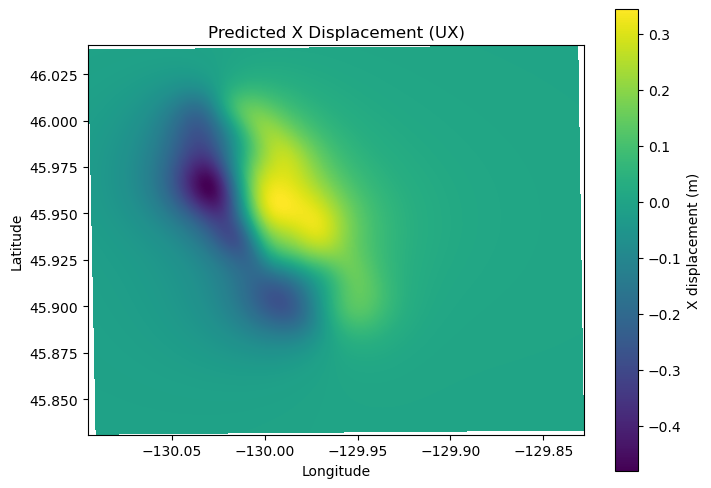

In [49]:
import matplotlib.pyplot as plt

# assume lat, lon, UZ are NumPy arrays of shape (Ny, Nx)
plt.figure(figsize=(8, 6))
plt.pcolormesh(lon, lat, UX, shading='auto')
plt.colorbar(label='X displacement (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted X Displacement (UX)')
plt.gca().set_aspect('equal', 'box')
plt.show()


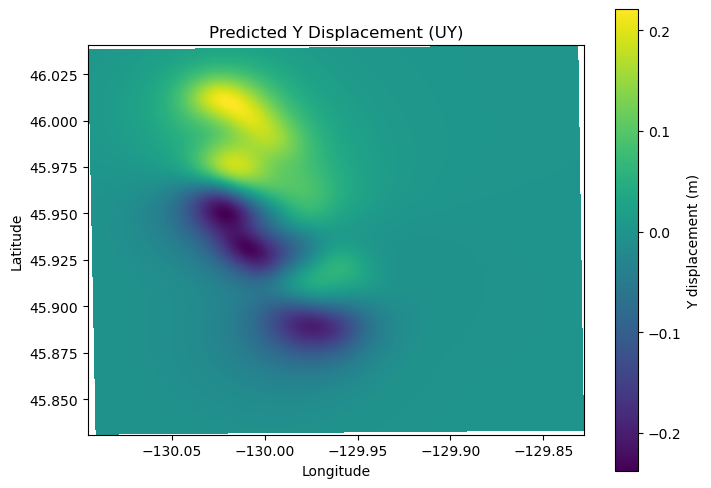

In [50]:
import matplotlib.pyplot as plt

# assume lat, lon, UZ are NumPy arrays of shape (Ny, Nx)
plt.figure(figsize=(8, 6))
plt.pcolormesh(lon, lat, UY, shading='auto')
plt.colorbar(label='Y displacement (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Y Displacement (UY)')
plt.gca().set_aspect('equal', 'box')
plt.show()


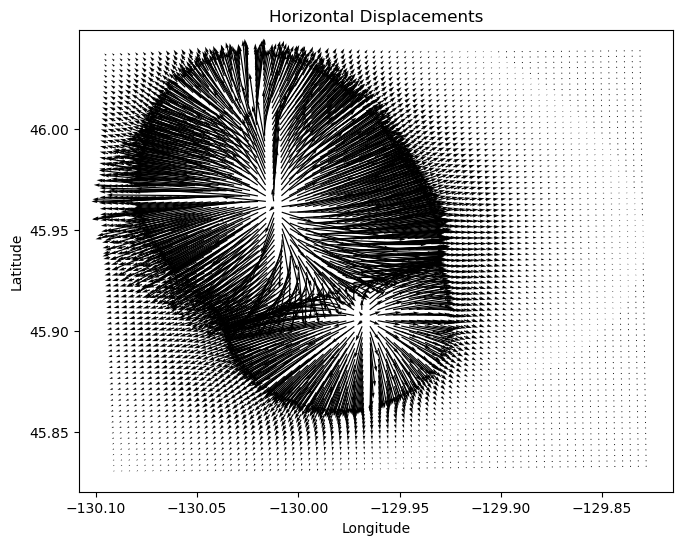

In [38]:
step = 15  # plot one arrow every 15 points
plt.figure(figsize=(8,6))
plt.quiver(
    lon[::step, ::step],
    lat[::step, ::step],
    UX[::step, ::step],
    UY[::step, ::step],
    scale=2,       # increase to shorten arrows
    width=0.002
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Horizontal Displacements')
plt.gca().set_aspect('equal','box')
plt.show()


In [43]:
import utm
import numpy as np

# your station table
stations = {
    '2501': (45.95480372, -130.0090668),
    '2502': (45.96257971, -129.9910622),
    '2503': (45.94700845, -130.0265777),
    '2504': (45.95882833, -130.0114997),
}

# project each into UTM (E,N)
XY = {}
for fid, (lat_s, lon_s) in stations.items():
    e, n, _, _ = utm.from_latlon(lat_s, lon_s)
    XY[fid] = (e, n)

# now XY['2502'] = (easting, northing) in same units as UX,UY grid


In [54]:
from scipy.interpolate import RegularGridInterpolator

# --- After UX, UY, UZ have been computed ---

# 1) Extract the 1D grid axes (easting, northing)
x1d = X[0, :]   # easting (meters)
y1d = Y[:, 0]   # northing (meters)

# 2) Build interpolators for the horizontal fields
interp_UX = RegularGridInterpolator((y1d, x1d), UX, bounds_error=False, fill_value=None)
interp_UY = RegularGridInterpolator((y1d, x1d), UY, bounds_error=False, fill_value=None)

# 3) Define your station lat/lon
stations = {
    '2501': (45.95480372, -130.0090668),
    '2502': (45.96257971, -129.9910622),
    '2503': (45.94700845, -130.0265777),
    '2504': (45.95882833, -130.0114997),
}

# 4) Project stations into UTM (same utm.from_latlon you used above)
station_utm = {}
for fid, (lat_s, lon_s) in stations.items():
    e, n, _, _ = utm.from_latlon(lat_s, lon_s)
    station_utm[fid] = (e, n)

# 5) Interpolate the horizontal displacement at each station
Ustat = {}
for fid, (e, n) in station_utm.items():
    ux_val = interp_UX((n, e))  # input order: (northing, easting)
    uy_val = interp_UY((n, e))
    Ustat[fid] = np.array([ux_val, uy_val])

# 6) Function to predict range‐change between two stations
def predict_range_change(fidA, fidB):
    eA, nA = station_utm[fidA]
    eB, nB = station_utm[fidB]
    baseline = np.array([eB - eA, nB - nA])
    L = np.linalg.norm(baseline)
    if L == 0:
        return 0.0
    u_hat = baseline / L
    dU = Ustat[fidB] - Ustat[fidA]
    return float(np.dot(dU, u_hat))

# 7) Compute and print predicted Δranges
pairs = [('2503','2504'),('2502','2504'),('2502','2503')]
for A, B in pairs:
    dr = predict_range_change(A, B)
    print(f"Predicted Δrange {A}→{B}: {dr:.4f} m")


Predicted Δrange 2503→2504: 0.3245 m
Predicted Δrange 2502→2504: 0.3664 m
Predicted Δrange 2502→2503: 0.7181 m


In [51]:
Ustat

{'2501': array([ 0.05417693, -0.107789  ]),
 '2502': array([0.33145477, 0.08988715]),
 '2503': array([-0.32556479, -0.21207103]),
 '2504': array([-0.00809732, -0.06251722])}

In [52]:
from scipy.interpolate import RegularGridInterpolator
import utm
import numpy as np

# ——— after you’ve built UX, UY, UZ on the mesh X, Y ———

# 1) Extract the 1D grid axes
x1d = X[0, :]   # easting (m)
y1d = Y[:, 0]   # northing (m)

# 2) Build interpolators for all three components
interp_UX = RegularGridInterpolator((y1d, x1d), UX, bounds_error=False, fill_value=None)
interp_UY = RegularGridInterpolator((y1d, x1d), UY, bounds_error=False, fill_value=None)
interp_UZ = RegularGridInterpolator((y1d, x1d), UZ, bounds_error=False, fill_value=None)

# 3) Your station lat/lon table
stations = {
    '2501': (45.95480372, -130.0090668),
    '2502': (45.96257971, -129.9910622),
    '2503': (45.94700845, -130.0265777),
    '2504': (45.95882833, -130.0114997),
}

# 4) Project stations into UTM so they match X/Y
station_utm = {}
for fid, (lat_s, lon_s) in stations.items():
    e, n, _, _ = utm.from_latlon(lat_s, lon_s)
    station_utm[fid] = (e, n)

# 5) Sample UX, UY, UZ at each station
Ustat = {}
for fid, (e, n) in station_utm.items():
    ux_s = interp_UX((n, e))
    uy_s = interp_UY((n, e))
    uz_s = interp_UZ((n, e))
    Ustat[fid] = np.array([ux_s, uy_s, uz_s])

# 6) Print per‐station vector
print("Station displacements (Ux, Uy, Uz) [m]:")
for fid, (ux_s, uy_s, uz_s) in Ustat.items():
    print(f"  {fid}: Ux = {ux_s:.4e}, Uy = {uy_s:.4e}, Uz = {uz_s:.4e}")


Station displacements (Ux, Uy, Uz) [m]:
  2501: Ux = 5.4177e-02, Uy = -1.0779e-01, Uz = 1.3606e+00
  2502: Ux = 3.3145e-01, Uy = 8.9887e-02, Uz = 7.6766e-01
  2503: Ux = -3.2556e-01, Uy = -2.1207e-01, Uz = 5.3369e-01
  2504: Ux = -8.0973e-03, Uy = -6.2517e-02, Uz = 1.4313e+00


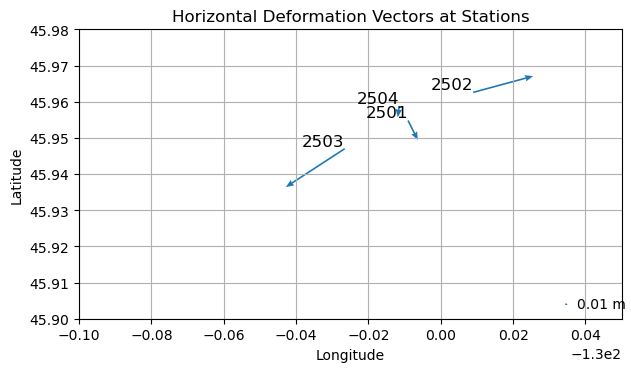

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# (1) Your station lat/lon and their horizontal displacements Ustat from before
station_ids = list(stations.keys())
lats = np.array([stations[s][0] for s in station_ids])
lons = np.array([stations[s][1] for s in station_ids])
Ux_s = np.array([Ustat[s][0] for s in station_ids])
Uy_s = np.array([Ustat[s][1] for s in station_ids])

# (2) Desired map limits
lon_min_plot, lon_max_plot = -130.1, -129.95
lat_min_plot, lat_max_plot = 45.9, 45.98

plt.figure(figsize=(7,10))
Q = plt.quiver(
    lons, lats, 
    Ux_s, Uy_s,
    angles='xy',
    scale_units='xy',
    scale=20,        # ← increase this to shorten arrows (try 40–200)
    width=0.003,     # thinner shafts
    headwidth=4,
    headlength=5,
    color='C0'
)

# station labels
for s, lon_s, lat_s in zip(station_ids, lons, lats):
    plt.text(lon_s, lat_s, s, fontsize=12, ha='right', va='bottom')

plt.xlim(lon_min_plot, lon_max_plot)
plt.ylim(lat_min_plot, lat_max_plot)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Horizontal Deformation Vectors at Stations')
plt.gca().set_aspect('equal','box')
plt.grid(True)

# optional: annotate a scale bar for arrow length
sample_len = 0.01  # e.g. 1 cm of deformation 
plt.quiverkey(Q, 0.9, 0.05, sample_len, f"{sample_len:.2f} m", labelpos='E')

plt.show()


In [53]:
# 7) (Optional) Predicted horizontal range‐change as before
def predict_range_change(fidA, fidB):
    eA, nA = station_utm[fidA]
    eB, nB = station_utm[fidB]
    baseline = np.array([eB-eA, nB-nA])
    L = np.linalg.norm(baseline)
    if L==0: return 0.0
    u_hat = baseline/L
    dU = Ustat[fidB][:2] - Ustat[fidA][:2]  # only Ux,Uy
    return float(np.dot(dU, u_hat))

for A, B in [('2503','2504'),('2502','2504'),('2502','2503')]:
    dr = predict_range_change(A, B)
    print(f"Predicted Δrange {A}→{B}: {dr:.4f} m")

Predicted Δrange 2503→2504: 0.3245 m
Predicted Δrange 2502→2504: 0.3664 m
Predicted Δrange 2502→2503: 0.7181 m


In [26]:
for name, arr in (("UX", UX), ("UY", UY), ("UZ", UZ)):
    print(name, "NaNs:", np.isnan(arr).sum(), "of", arr.size)


UX NaNs: 1176192 of 1176192
UY NaNs: 1176192 of 1176192
UZ NaNs: 1176192 of 1176192


In [29]:
ux0, uy0, uz0 = get_displacement_array(X, Y, patches[0], m[0])
print("Patch 0 → UZ0 valid:", np.isfinite(uz0).sum(), 
      "UX0 valid:", np.isfinite(ux0).sum())


Patch 0 → UZ0 valid: 1176192 UX0 valid: 1176192
